In [2]:
import sys
import gzip
import itertools

from pathlib import Path

import numpy
import pandas 
import tensorflow 

import matplotlib.pyplot as plt
from sklearn import metrics

from deeplucia_toolkit import make_dataset
from deeplucia_toolkit import misc

2024-05-31 18:44:14.089865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 18:44:14.091746: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 18:44:14.095167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 18:44:14.553319: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
resolution = 5000

keras_model_filename = "model/trained.h5"
chrom = "chr10"
sample = "B001"

scan_start = 0     # scan_start = 1000 # scan_start = 1000
scan_end   = 26137 # scan_end   = 2000 # scan_end   = 1020

marker_type = "r2_030M"
genome_version = "mm10" 

feature_dirname =  Path.cwd() / "feature"
result_dirname =  Path.cwd() / "result"
result_dirname.mkdir(parents=True,exist_ok=True)

prediction_filename = result_dirname / "score.xls.gz"
loop_bedpe_filename = result_dirname / "loop.bedpe"

positive_df_filename = feature_dirname / "positive_loops/mm10/B001/positive_loop.chr10.txt"

In [4]:
model = misc.load_model(keras_model_filename)

2024-05-31 18:44:36.153097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78827 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [5]:
seq_array_dirname,epi_array_dirname,con_array_dirname = misc.get_directory(feature_dirname,chrom,sample,genome_version)
chrom_sample = (chrom,sample)
chrom_sample_list = [chrom_sample]

chrom_to_seq_array = make_dataset.load_seq_array_dir(chrom_sample_list, seq_array_dirname)
chrom_sample_to_epi_array = make_dataset.load_epi_array_dir(chrom_sample_list , marker_type , epi_array_dirname)
chrom_sample_to_con_array = make_dataset.load_con_array_dir(chrom_sample_list , con_array_dirname)

con_array = chrom_sample_to_con_array[chrom_sample]

In [6]:
scanning_loop_candidate_gen = make_dataset.gen_scanning_loop_candidate(chrom,sample,scan_start,scan_end)

In [ ]:
pair_list = []
prob_list = []

for _,chunk in itertools.groupby(enumerate(scanning_loop_candidate_gen) , lambda x : x[0]//32768):
    loop_candidate_list = []
    for _,loop_candidate in chunk:
        pair = loop_candidate[2]
        loop_candidate_list.append(loop_candidate)
        pair_list.append(pair)

    batched_feature,_ = make_dataset.extract_seq_epi_dataset_nonshuffle(loop_candidate_list, chrom_to_seq_array, chrom_sample_to_epi_array)
    output = model.predict(batched_feature)
    batched_prob_pred = numpy.squeeze(output,axis=1)

    for prob in batched_prob_pred:
        prob_list.append(prob)


In [ ]:
if len(pair_list) == len(prob_list):
    with gzip.open(prediction_filename,"wt") as prediction_file:
        prediction_file.write("chrom\tindex_one\tindex_two\tprob\n")
        for pair,prob in zip(pair_list,prob_list):
            prediction_file.write("\t".join(map(str,[chrom, pair[0],pair[1], prob])) + "\n")


In [8]:
loop_df = pandas.read_table(prediction_filename)

In [9]:
dist_filtered_loop_df = misc.filter_by_distance(loop_df)

In [10]:
cutoff_filtered_loop_df = misc.filter_by_quantile(dist_filtered_loop_df,con_array)

In [11]:
clustered_loop_df = misc.form_loop_cluster(cutoff_filtered_loop_df)

In [12]:
misc.save_as_bedpe(clustered_loop_df,chrom,resolution,loop_bedpe_filename)

In [13]:
positive_df = pandas.read_table(positive_df_filename)

In [14]:
labeled_loop_df = loop_df.merge(positive_df,how="left",on =["index_one","index_two"])
labeled_loop_df["is_loop"] = numpy.where(labeled_loop_df["loop_id"].isnull(), 0, 1)

In [15]:
fpr,tpr,threshold = metrics.roc_curve(labeled_loop_df["is_loop"].values,labeled_loop_df["prob"].values)
au_ro_curve = metrics.roc_auc_score(labeled_loop_df["is_loop"].values,labeled_loop_df["prob"].values)

In [16]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=au_ro_curve,estimator_name='scDeepLUCIA')

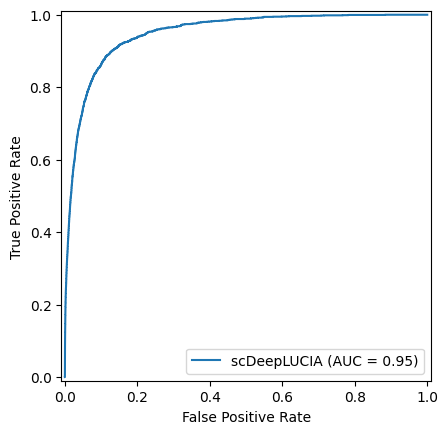

In [17]:
display.plot()